пип инстоллы

In [1]:
!pip install albumentations --quiet
!pip install opencv-python --quiet

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (5).json


{'kaggle (5).json': b'{"username":"antonlite","key":"50a7f3d218c35d64952eb1fe7007b19b"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c dl-2025-competition-1
!unzip dl-2025-competition-1.zip

dl-2025-competition-1.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  dl-2025-competition-1.zip
replace data/test/0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# импорт библиотек

In [4]:
import numpy as np
import pandas as pd
import cv2
import re
import copy
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from torch.nn.functional import interpolate
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.models import efficientnet_b0
import matplotlib.image as mpimg
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

from tqdm import tqdm

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# 1) Проанализировать данные, посмотреть на баланс классов, посмотреть на представителей классов, сделать выводы

       количество картинок
count               100.00
mean                 95.10
std                  35.44
min                  32.00
25%                  67.50
50%                 100.00
75%                 125.50
max                 150.00

 Мода: 44


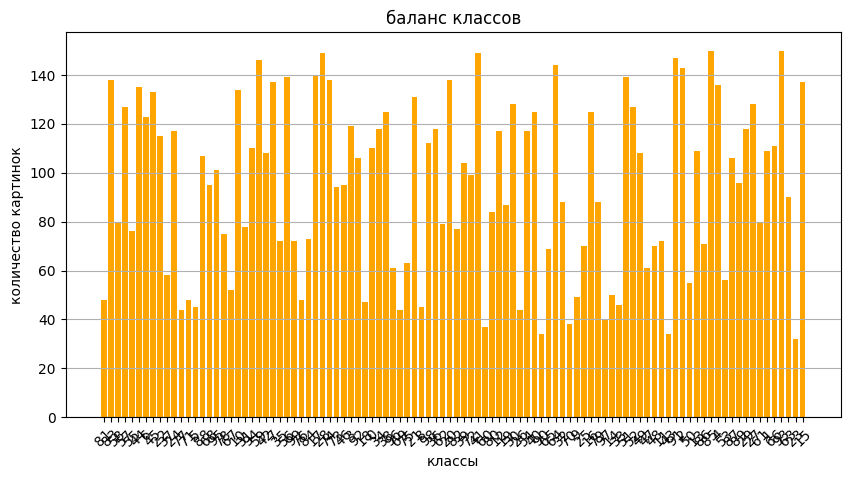

In [5]:
train_path = '/content/data/train'
class_counts = {}

# Считаем изображения по классам
for class_name in os.listdir(train_path):
    class_folder = os.path.join(train_path, class_name)
    if os.path.isdir(class_folder):
        images = os.listdir(class_folder)
        class_counts[class_name] = len(images)

# Сохраняем значения в DataFrame
df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['количество картинок'])
df.index.name = 'класс'

# Статистика
print(df.describe().round(2))

# Дополнительно — мода
mode_val = df['количество картинок'].mode().values[0]
print(f"\n Мода: {mode_val}")

# Визуализация
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='orange')
plt.title('баланс классов')
plt.xlabel('классы')
plt.ylabel('количество картинок')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# вывод по 1 заданию:
Дисбаланс классов умеренно выраженный: разница между самыми "крупными" и самыми "мелкими" классами — почти 5 раз; некоторые классы (min = 32) представлены очень слабо; std довольно большое

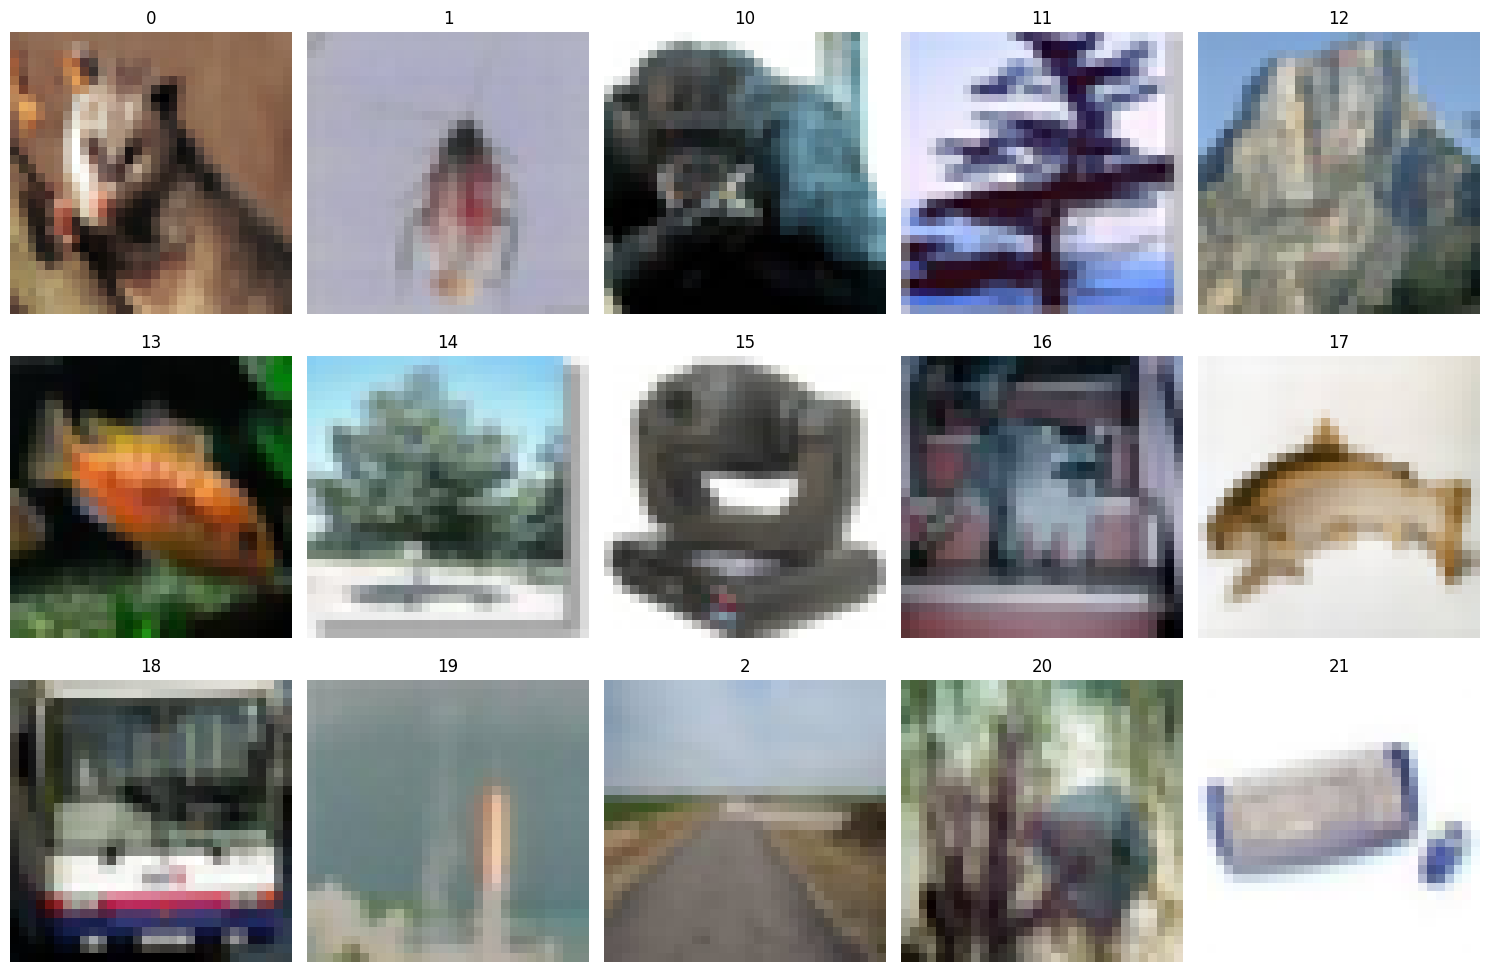

In [6]:
# Получаем список классов
classes = sorted(os.listdir(train_path))

# Собираем по одному изображению для каждого класса
class_images = {}
for class_name in classes[:15]:  # Ограничиваем до 15 классов
    class_dir = os.path.join(train_path, class_name)
    files = sorted(os.listdir(class_dir))
    if files:
        img_path = os.path.join(class_dir, files[0])
        class_images[class_name] = img_path

# Выводим по одной картинке каждого класса
plt.figure(figsize=(15, 10))
for i, (class_name, img_path) in enumerate(class_images.items()):
    plt.subplot(3, 5, i + 1)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')
plt.tight_layout()
plt.show()

# 2) Проанализировать хороший аугментационный пайплайн с помощью albumentations. Собрать подготовленный пайплайн в погрузчик данных на модель.

In [7]:
train_transforms = A.Compose([
    A.Resize(224, 224), # приведение к общему размеру для подачи в модель
    A.HorizontalFlip(p=0.5), # отражение по горизонтали, полезно при симметричных объектах
    A.RandomBrightnessContrast(p=0.2), # модель будет устойчивей к разному освещению
    A.Rotate(limit=20, p=0.3), # Сделает модель устойчивее к небольшим поворотам
    A.Affine(scale=(0.9, 1.1), translate_percent=(0.05, 0.05), rotate=(-10, 10), p=0.3), # случайный масштаб, сдвиг, поворот = устойчивость к расположению объектов
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # стандартизация значений пикселей
    ToTensorV2() # перевод изображения в формат PyTorch
])

In [8]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.img_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(root_dir))

        class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

        for class_name in self.classes:
            class_path = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_path):
                self.img_paths.append(os.path.join(class_path, img_name))
                self.labels.append(class_to_idx[class_name])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = self.labels[idx]

        if self.transform:
            transformed = self.transform(image=image)
            image = transformed["image"]
        else:
            image = torch.tensor(image / 255.0, dtype=torch.float).permute(2, 0, 1)

        return image, label

# 3) Поделить данные на трейн-валидацию

In [9]:
dataset = datasets.ImageFolder(root=train_path)

val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Тренировочная выборка: {len(train_dataset)}")
print(f"Валидационная выборка: {len(val_dataset)}")

Тренировочная выборка: 7608
Валидационная выборка: 1902


# Обучение базовой модели с transfer learning

базовые аугментации

Using device: cuda:0


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch [1/30]


Validating: 100%|██████████| 60/60 [00:02<00:00, 20.07it/s]


Train loss: 3.2291, accuracy: 0.2775
Val loss:   2.1563, accuracy: 0.4842
Model saved!

Epoch [2/30]


Validating: 100%|██████████| 60/60 [00:03<00:00, 19.43it/s]


Train loss: 1.9336, accuracy: 0.5396
Val loss:   1.6499, accuracy: 0.5699
Model saved!

Epoch [3/30]


Validating: 100%|██████████| 60/60 [00:03<00:00, 15.87it/s]


Train loss: 1.4472, accuracy: 0.6349
Val loss:   1.4379, accuracy: 0.6162
Model saved!

Epoch [4/30]


Validating: 100%|██████████| 60/60 [00:04<00:00, 14.33it/s]


Train loss: 1.1196, accuracy: 0.7213
Val loss:   1.3135, accuracy: 0.6451
Model saved!

Epoch [5/30]


Validating: 100%|██████████| 60/60 [00:03<00:00, 16.18it/s]


Train loss: 0.8964, accuracy: 0.7771
Val loss:   1.2496, accuracy: 0.6509
Model saved!

Epoch [6/30]


Validating: 100%|██████████| 60/60 [00:03<00:00, 19.41it/s]


Train loss: 0.7155, accuracy: 0.8325
Val loss:   1.2023, accuracy: 0.6661
Model saved!

Epoch [7/30]


Validating: 100%|██████████| 60/60 [00:03<00:00, 19.45it/s]


Train loss: 0.5616, accuracy: 0.8715
Val loss:   1.2066, accuracy: 0.6646

Epoch [8/30]


Validating: 100%|██████████| 60/60 [00:03<00:00, 18.90it/s]


Train loss: 0.4394, accuracy: 0.9037
Val loss:   1.1817, accuracy: 0.6714
Model saved!

Epoch [9/30]


Validating: 100%|██████████| 60/60 [00:03<00:00, 18.73it/s]


Train loss: 0.3474, accuracy: 0.9274
Val loss:   1.2078, accuracy: 0.6609

Epoch [10/30]


Validating: 100%|██████████| 60/60 [00:03<00:00, 18.82it/s]


Train loss: 0.2732, accuracy: 0.9460
Val loss:   1.1734, accuracy: 0.6761
Model saved!

Epoch [11/30]


Validating: 100%|██████████| 60/60 [00:03<00:00, 18.53it/s]


Train loss: 0.2116, accuracy: 0.9627
Val loss:   1.2150, accuracy: 0.6619

Epoch [12/30]


Validating: 100%|██████████| 60/60 [00:03<00:00, 18.64it/s]


Train loss: 0.1692, accuracy: 0.9706
Val loss:   1.2363, accuracy: 0.6583

Epoch [13/30]


Validating: 100%|██████████| 60/60 [00:03<00:00, 18.04it/s]


Train loss: 0.1503, accuracy: 0.9720
Val loss:   1.2680, accuracy: 0.6598

Epoch [14/30]


Validating: 100%|██████████| 60/60 [00:03<00:00, 18.52it/s]


Train loss: 0.1242, accuracy: 0.9787
Val loss:   1.2280, accuracy: 0.6688

Epoch [15/30]


Validating: 100%|██████████| 60/60 [00:03<00:00, 19.22it/s]


Train loss: 0.0967, accuracy: 0.9855
Val loss:   1.2946, accuracy: 0.6588
Early stopping triggered.


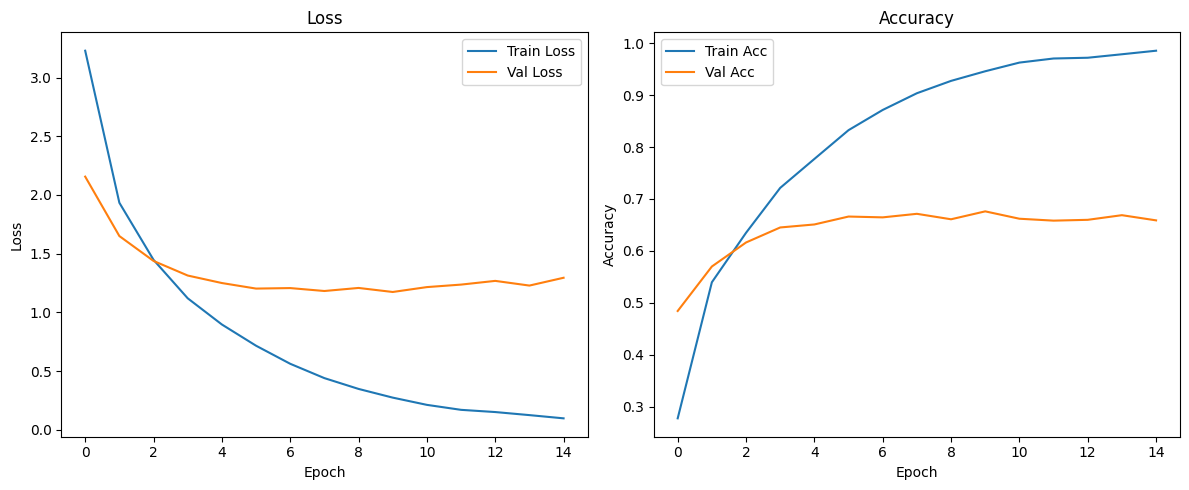

Predicting: 100%|██████████| 122/122 [00:07<00:00, 16.74it/s]

Predictions saved to predictions_resnet18.csv


In [10]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.dummy_image = np.zeros((224, 224, 3), dtype=np.uint8)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = cv2.imread(img_path)
            if image is None:
                print(f"Warning: Could not read image {img_path}, using dummy image")
                image = self.dummy_image
            else:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


                if image.shape[0] < 10 or image.shape[1] < 10:
                    print(f"Warning: Small image size {image.shape} for {img_path}, using dummy image")
                    image = self.dummy_image
        except Exception as e:
            print(f"Error processing image {img_path}: {str(e)}")
            image = self.dummy_image

        label = self.labels[idx]


        if self.transform:
            try:
                augmented = self.transform(image=image)
                image = augmented['image']
            except Exception as e:
                print(f"Error transforming image {img_path}: {str(e)}")
                augmented = self.transform(image=self.dummy_image)
                image = augmented['image']

        return image, label


def prepare_data(root_dir):
    classes = sorted(os.listdir(root_dir))
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
    image_paths, labels = [], []

    for class_name in classes:
        class_path = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        for img_name in os.listdir(class_path):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(class_path, img_name)
                image_paths.append(img_path)
                labels.append(class_to_idx[class_name])

    return image_paths, labels, classes, class_to_idx


train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Resize(224, 224),
    A.Normalize(),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(),
    ToTensorV2()
])

root_dir = '/content/data/train'
image_paths, labels, classes, class_to_idx = prepare_data(root_dir)

train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels
)

train_dataset = CustomDataset(train_imgs, train_labels, transform=train_transform)
val_dataset = CustomDataset(val_imgs, val_labels, transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(classes))
model = model.to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()


def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for imgs, labels in tqdm(loader, desc="Training"):
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / len(loader), correct / total

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Validating"):
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / len(loader), correct / total


epochs = 30
patience = 5
best_val_loss = float('inf')
patience_counter = 0

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    print(f"\nEpoch [{epoch+1}/{epochs}]")

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}")
    print(f"Val loss:   {val_loss:.4f}, accuracy: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("Model saved!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.savefig("training_curves.png")
plt.show()

# Подготовка тестовых данных
def load_test_images(test_dir):
    test_imgs = []
    for root, _, files in os.walk(test_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                test_imgs.append(os.path.join(root, file))
    return test_imgs

test_dir = '/content/data/test'
test_imgs = load_test_images(test_dir)


test_dataset = CustomDataset(test_imgs, [0]*len(test_imgs), transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=1)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

predictions = []
file_ids = []

with torch.no_grad():
    for imgs, _ in tqdm(test_loader, desc="Predicting"):
        try:
            imgs = imgs.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
        except Exception as e:
            print(f"Error during prediction: {str(e)}")
            predictions.extend([random.randint(0, len(classes)-1) for _ in range(imgs.size(0))])

idx_to_class = {idx: class_name for class_name, idx in class_to_idx.items()}
predictions_names = [idx_to_class[pred] for pred in predictions]
file_ids = [os.path.basename(img_path) for img_path in test_imgs]

df = pd.DataFrame({'id': file_ids, 'target': predictions_names})
df.to_csv('predictions_resnet18.csv', index=False)
print("Predictions saved to predictions_resnet18.csv")

сложные аугментации

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-11-ff70206eafec>:71: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.wa

Using device: cuda:0
Эпоха [1/10]
Train loss: 3.8304, Train accuracy: 0.1547
Val loss: 2.5689, Val accuracy: 0.3975

Эпоха [2/10]
Train loss: 2.8268, Train accuracy: 0.3302
Val loss: 2.0079, Val accuracy: 0.4706

Эпоха [3/10]
Train loss: 2.4080, Train accuracy: 0.4026
Val loss: 1.7853, Val accuracy: 0.5210

Эпоха [4/10]
Train loss: 2.1533, Train accuracy: 0.4585
Val loss: 1.6622, Val accuracy: 0.5552

Эпоха [5/10]
Train loss: 1.9929, Train accuracy: 0.4904
Val loss: 1.5740, Val accuracy: 0.5789

Эпоха [6/10]
Train loss: 1.8628, Train accuracy: 0.5168
Val loss: 1.5136, Val accuracy: 0.5873

Эпоха [7/10]
Train loss: 1.7343, Train accuracy: 0.5451
Val loss: 1.4422, Val accuracy: 0.5999

Эпоха [8/10]
Train loss: 1.6277, Train accuracy: 0.5691
Val loss: 1.4170, Val accuracy: 0.6220

Эпоха [9/10]
Train loss: 1.5447, Train accuracy: 0.5914
Val loss: 1.3779, Val accuracy: 0.6204

Эпоха [10/10]
Train loss: 1.4586, Train accuracy: 0.6094
Val loss: 1.3723, Val accuracy: 0.6162



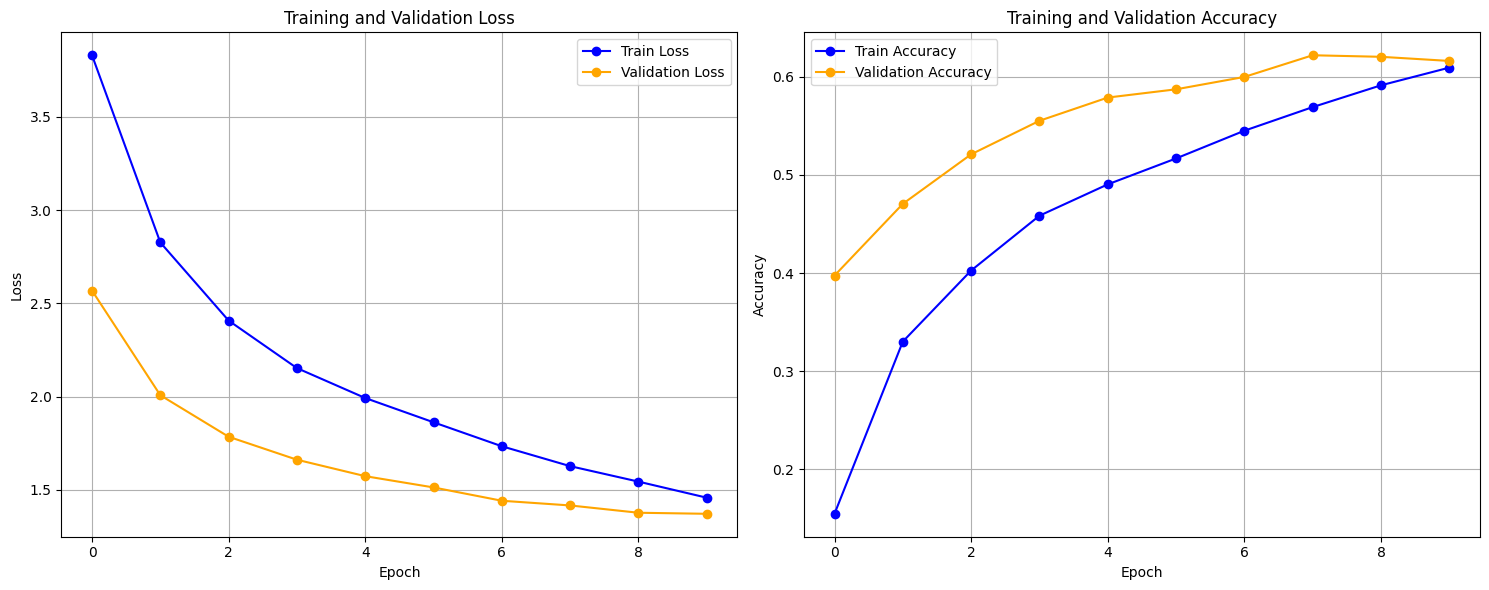


Лучшие результаты на валидации:
Эпоха: 10
Val Loss: 1.3723
Val Accuracy: 0.6162
Соответствующий Train Loss: 1.4586
Соответствующий Train Accuracy: 0.6094


In [11]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

        self.image_paths = []
        self.labels = []

        for class_name in self.classes:
            class_path = os.path.join(self.root_dir, class_name)
            for img_name in os.listdir(class_path):
                self.image_paths.append(os.path.join(class_path, img_name))
                self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = cv2.imread(img_path)
            if image is None:
                raise ValueError(f"Could not read image {img_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            image = np.zeros((224, 224, 3), dtype=np.uint8)

        label = self.labels[idx]

        if self.transform:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label


class TransformedSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        image, label = self.subset[idx]
        if self.transform:
            if torch.is_tensor(image):
                image = image.numpy().transpose(1, 2, 0)
            transformed = self.transform(image=image)
            image = transformed["image"]
        return image, label

    def __len__(self):
        return len(self.subset)

train_transform = A.Compose([
    A.SmallestMaxSize(max_size=256),
    A.RandomCrop(height=224, width=224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.7),
    A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2, p=0.5),
    A.OneOf([
        A.MotionBlur(blur_limit=5, p=0.5),
        A.MedianBlur(blur_limit=5, p=0.5),
        A.GaussianBlur(blur_limit=5, p=0.5),
    ], p=0.3),
    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
        A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), p=0.5),
    ], p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

train_path = "/content/data/train"
dataset = CustomDataset(root_dir=train_path, transform=None)

indices = list(range(len(dataset)))
train_indices, val_indices = train_test_split(
    indices, test_size=0.2, stratify=dataset.labels
)


train_dataset = TransformedSubset(Subset(dataset, train_indices), transform=train_transform)
val_dataset = TransformedSubset(Subset(dataset, val_indices), transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(dataset.classes))
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / len(loader), correct / total

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / len(loader), correct / total

train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

epochs = 10
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model, val_loader, criterion)


    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f"Эпоха [{epoch+1}/{epochs}]")
    print(f"Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f}")
    print(f"Val loss: {val_loss:.4f}, Val accuracy: {val_acc:.4f}\n")

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss', color='blue', marker='o')
plt.plot(val_loss_history, label='Validation Loss', color='orange', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy', color='blue', marker='o')
plt.plot(val_acc_history, label='Validation Accuracy', color='orange', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

best_val_epoch = np.argmin(val_loss_history)
print(f"\nЛучшие результаты на валидации:")
print(f"Эпоха: {best_val_epoch+1}")
print(f"Val Loss: {val_loss_history[best_val_epoch]:.4f}")
print(f"Val Accuracy: {val_acc_history[best_val_epoch]:.4f}")
print(f"Соответствующий Train Loss: {train_loss_history[best_val_epoch]:.4f}")
print(f"Соответствующий Train Accuracy: {train_acc_history[best_val_epoch]:.4f}")

## без transfer learning


базовые аугментации

Using device: cuda:0
Эпоха [1/10]
Train loss: 4.2801, Train accuracy: 0.0548
Val loss: 3.9710, Val accuracy: 0.0899

Эпоха [2/10]
Train loss: 3.8663, Train accuracy: 0.1062
Val loss: 3.6423, Val accuracy: 0.1504

Эпоха [3/10]
Train loss: 3.6576, Train accuracy: 0.1380
Val loss: 3.5557, Val accuracy: 0.1656

Эпоха [4/10]
Train loss: 3.5394, Train accuracy: 0.1593
Val loss: 3.4462, Val accuracy: 0.1735

Эпоха [5/10]
Train loss: 3.4072, Train accuracy: 0.1781
Val loss: 3.3420, Val accuracy: 0.1972

Эпоха [6/10]
Train loss: 3.3001, Train accuracy: 0.1987
Val loss: 3.2552, Val accuracy: 0.2166

Эпоха [7/10]
Train loss: 3.1927, Train accuracy: 0.2175
Val loss: 3.2328, Val accuracy: 0.2213

Эпоха [8/10]
Train loss: 3.0991, Train accuracy: 0.2338
Val loss: 3.1914, Val accuracy: 0.2287

Эпоха [9/10]
Train loss: 3.0146, Train accuracy: 0.2472
Val loss: 3.1549, Val accuracy: 0.2413

Эпоха [10/10]
Train loss: 2.9262, Train accuracy: 0.2563
Val loss: 3.1738, Val accuracy: 0.2424



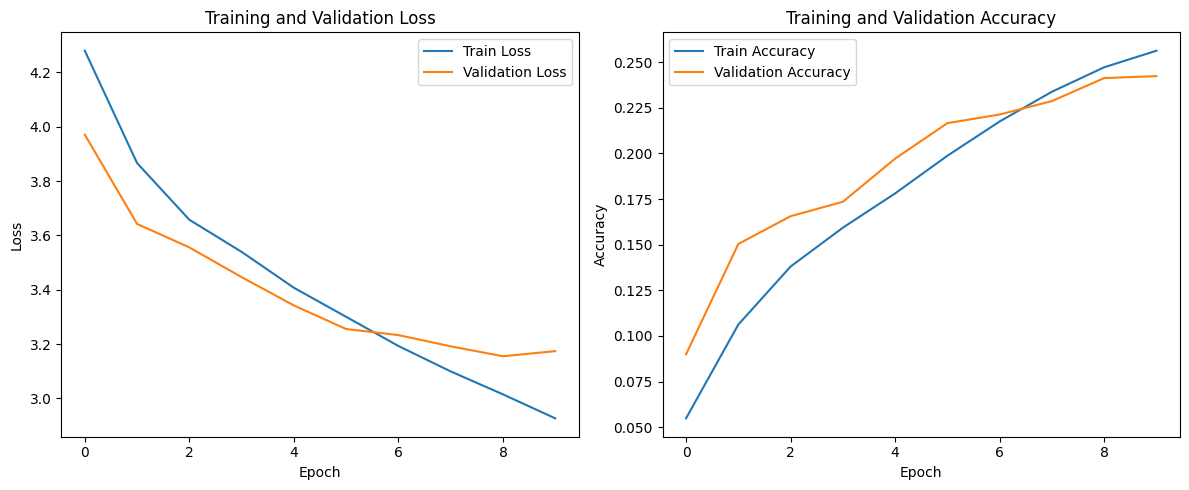

Predictions saved to predictions_efficientnet_b0.csv


In [12]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, label

train_path = '/content/data/train'
class_names = sorted(os.listdir(train_path))
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}
image_paths = []
labels = []

for class_name in class_names:
    class_folder = os.path.join(train_path, class_name)
    for img_name in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_name)
        image_paths.append(img_path)
        labels.append(class_to_idx[class_name])

train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels
)
train_transform = A.Compose([
    A.SmallestMaxSize(max_size=256),
    A.RandomCrop(height=224, width=224),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])
train_dataset = CustomDataset(train_imgs, train_labels, transform=train_transform)
val_dataset = CustomDataset(val_imgs, val_labels, transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN(len(class_names)).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / len(loader), correct / total

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / len(loader), correct / total
epochs = 10
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model, val_loader, criterion)

    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f"Эпоха [{epoch+1}/{epochs}]")
    print(f"Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f}")
    print(f"Val loss: {val_loss:.4f}, Val accuracy: {val_acc:.4f}\n")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

def get_predictions(model, loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for imgs, _ in loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
    return predictions

val_predictions = get_predictions(model, val_loader)

predictions_df = pd.DataFrame({
    'id': range(len(val_predictions)),
    'target': val_predictions
})

predictions_df.to_csv('predictions_efficientnet_b0.csv', index=False)
print("Predictions saved to predictions_efficientnet_b0.csv")

продвинутые аугментации

Using device: cuda:0


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-13-6621110def2a>:54: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


Эпоха [1/10]
Train loss: 4.6109, Train accuracy: 0.0143
Val loss: 4.5316, Val accuracy: 0.0168

Эпоха [2/10]
Train loss: 4.5298, Train accuracy: 0.0181
Val loss: 4.4648, Val accuracy: 0.0205

Эпоха [3/10]
Train loss: 4.4785, Train accuracy: 0.0280
Val loss: 4.3315, Val accuracy: 0.0436

Эпоха [4/10]
Train loss: 4.3573, Train accuracy: 0.0394
Val loss: 4.1580, Val accuracy: 0.0731

Эпоха [5/10]
Train loss: 4.2484, Train accuracy: 0.0544
Val loss: 4.0711, Val accuracy: 0.0846

Эпоха [6/10]
Train loss: 4.1475, Train accuracy: 0.0632
Val loss: 3.9680, Val accuracy: 0.1009

Эпоха [7/10]
Train loss: 4.0786, Train accuracy: 0.0741
Val loss: 3.8748, Val accuracy: 0.1146

Эпоха [8/10]
Train loss: 4.0257, Train accuracy: 0.0843
Val loss: 3.8235, Val accuracy: 0.1036

Эпоха [9/10]
Train loss: 3.9800, Train accuracy: 0.0928
Val loss: 3.8143, Val accuracy: 0.1109

Эпоха [10/10]
Train loss: 3.9364, Train accuracy: 0.1021
Val loss: 3.7134, Val accuracy: 0.1246



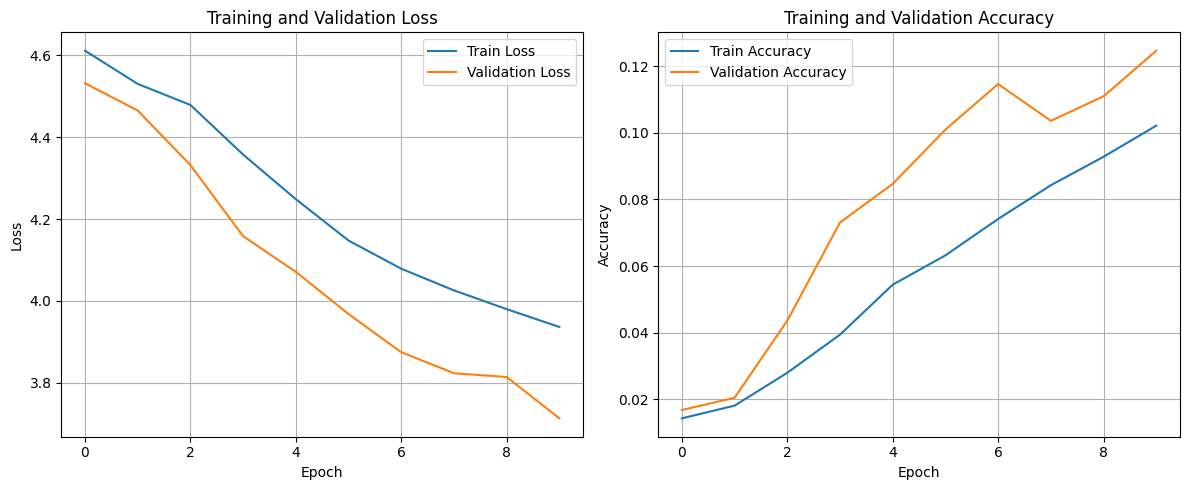

In [13]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = cv2.imread(img_path)
            if image is None:
                raise ValueError(f"Could not read image {img_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            image = np.zeros((224, 224, 3), dtype=np.uint8)

        label = self.labels[idx]

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, label


train_path = "/content/data/train"
class_names = sorted(os.listdir(train_path))
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}
image_paths = []
labels = []

for class_name in class_names:
    class_folder = os.path.join(train_path, class_name)
    for img_name in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_name)
        image_paths.append(img_path)
        labels.append(class_to_idx[class_name])

train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels
)

train_transform = A.Compose([
    A.SmallestMaxSize(max_size=256),
    A.RandomCrop(height=224, width=224),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

train_dataset = CustomDataset(train_imgs, train_labels, transform=train_transform)
val_dataset = CustomDataset(val_imgs, val_labels, transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN(len(class_names)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / len(loader), correct / total

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / len(loader), correct / total

train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

epochs = 10
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model, val_loader, criterion)

    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f"Эпоха [{epoch+1}/{epochs}]")
    print(f"Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f}")
    print(f"Val loss: {val_loss:.4f}, Val accuracy: {val_acc:.4f}\n")


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# СКОР НА КАГЛЕ

вместе с графиками лосей и метрик, ранней остановкой и тд.

Device: cuda
Классы: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
Количество классов: 100
Словарь меток: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, '11': 11, '12': 12, '13': 13, '14': 14, '15': 15, '16': 16, '17': 17, '18': 18, '19': 19, '20': 20, '21': 21, '22': 22, '23': 23, '24': 24, '25': 25, '26': 26, '27': 27, '28': 28, '29': 29, '30': 30, '31': 31, '32': 32, '33': 33, '34': 34, '35': 35, '36': 36

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Val: 100%|██████████| 60/60 [00:05<00:00, 10.02it/s]


Epoch [1/20] Train Loss: 3.5463 Acc: 0.2301 | Val Loss: 4.6479 Acc: 0.1130


Val: 100%|██████████| 60/60 [00:04<00:00, 12.42it/s]


Epoch [2/20] Train Loss: 2.3733 Acc: 0.5051 | Val Loss: 5.1933 Acc: 0.0137


Val: 100%|██████████| 60/60 [00:05<00:00, 11.26it/s]


Epoch [3/20] Train Loss: 1.9676 Acc: 0.6232 | Val Loss: 2.9562 Acc: 0.3896


Val: 100%|██████████| 60/60 [00:05<00:00, 10.65it/s]


Epoch [4/20] Train Loss: 1.7296 Acc: 0.6988 | Val Loss: 4.0776 Acc: 0.1435


Val: 100%|██████████| 60/60 [00:05<00:00, 11.94it/s]


Epoch [5/20] Train Loss: 1.5400 Acc: 0.7667 | Val Loss: 3.9060 Acc: 0.2161


Val: 100%|██████████| 60/60 [00:06<00:00,  9.92it/s]


Epoch [6/20] Train Loss: 1.4099 Acc: 0.8136 | Val Loss: 5.2904 Acc: 0.0810


Val: 100%|██████████| 60/60 [00:04<00:00, 12.07it/s]


Epoch [7/20] Train Loss: 1.3057 Acc: 0.8538 | Val Loss: 2.1361 Acc: 0.6020


Val: 100%|██████████| 60/60 [00:05<00:00, 11.71it/s]


Epoch [8/20] Train Loss: 1.2219 Acc: 0.8792 | Val Loss: 3.2738 Acc: 0.3612


Val: 100%|██████████| 60/60 [00:05<00:00, 10.09it/s]


Epoch [9/20] Train Loss: 1.1481 Acc: 0.9130 | Val Loss: 2.4148 Acc: 0.5515


Val: 100%|██████████| 60/60 [00:04<00:00, 12.28it/s]


Epoch [10/20] Train Loss: 1.0880 Acc: 0.9310 | Val Loss: 2.9128 Acc: 0.4154


Val: 100%|██████████| 60/60 [00:05<00:00, 10.03it/s]


Epoch [11/20] Train Loss: 1.0584 Acc: 0.9408 | Val Loss: 2.3840 Acc: 0.5494


Val: 100%|██████████| 60/60 [00:04<00:00, 12.38it/s]


Epoch [12/20] Train Loss: 1.0358 Acc: 0.9498 | Val Loss: 2.1967 Acc: 0.6120
Early stopping!


Predicting: 100%|██████████| 122/122 [00:10<00:00, 11.28it/s]


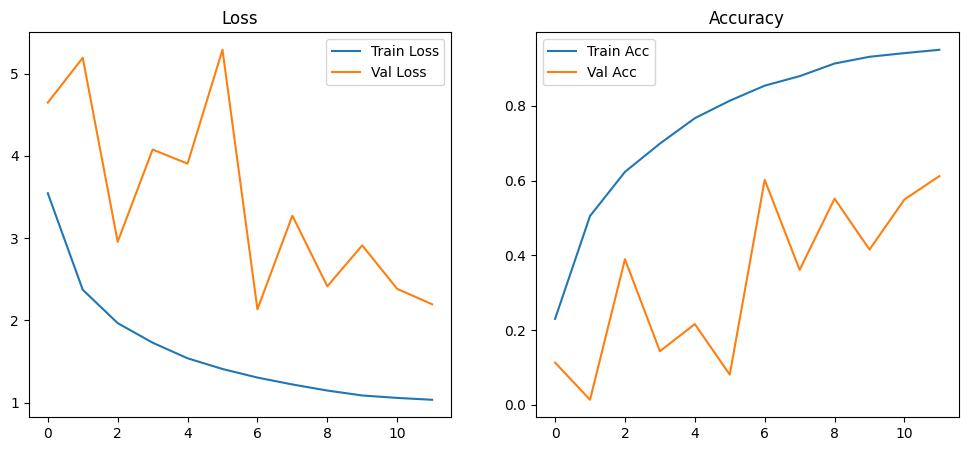

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import cv2
import os
import re
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from torchvision.models import efficientnet_b0


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
train_path = '/content/data/train'
test_path = '/content/data/test'


def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]


class_names = sorted(os.listdir(train_path), key=natural_sort_key)  # Сортируем папки с помощью natural_sort_key
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}
num_classes = len(class_names)
print(f"Классы: {class_names}")
print(f"Количество классов: {num_classes}")
print(f"Словарь меток: {class_to_idx}")

# Сбор изображений (упорядочивание файлов внутри папок)
image_paths, labels = [], []
for class_name in class_names:
    class_folder = os.path.join(train_path, class_name)
    if not os.path.isdir(class_folder):
        raise ValueError(f"Папка {class_folder} не существует")

    img_names = sorted(os.listdir(class_folder), key=natural_sort_key)
    for img_name in img_names:
        image_paths.append(os.path.join(class_folder, img_name))
        labels.append(class_to_idx[class_name])

train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels,
)


test_image_paths = [os.path.join(test_path, img) for img in sorted(os.listdir(test_path), key=natural_sort_key)]

# Аугментации
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Датасеты
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels=None, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        if img is None:
            raise ValueError(f"Failed to load image: {self.image_paths[idx]}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype('float32') / 255.0
        if self.transform:
            img = self.transform(image=img)['image']
        if self.labels is not None:
            return img, self.labels[idx]
        return img, self.image_paths[idx]

train_dataset = CustomDataset(train_imgs, train_labels, transform=train_transform)
val_dataset = CustomDataset(val_imgs, val_labels, transform=val_transform)
test_dataset = CustomDataset(test_image_paths, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# Модель EfficientNet-B0
model = efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

# Функция потерь
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, x, target):
        confidence = 1.0 - self.smoothing
        logprobs = torch.nn.functional.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1)).squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        return (confidence * nll_loss + self.smoothing * smooth_loss).mean()

criterion = LabelSmoothingCrossEntropy()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

# Обучение
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for imgs, labels in tqdm(loader, desc="Train"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

def validate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Val"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total

# Тренировка с Early Stopping
best_model_wts = copy.deepcopy(model.state_dict())
best_loss = np.inf
patience, counter = 5, 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

max_epochs = 20

for epoch in range(max_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model, val_loader, criterion)
    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{max_epochs}] Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping!")
            break

model.load_state_dict(best_model_wts)

# Предсказания
model.eval()
predictions = []

with torch.no_grad():
    for imgs, _ in tqdm(test_loader, desc="Predicting"):
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())

# Сохранение с именами классов
idx_to_class = {idx: class_name for class_name, idx in class_to_idx.items()}
predictions_names = [idx_to_class[pred] for pred in predictions]
df = pd.DataFrame({'id': list(range(len(predictions))), 'target': predictions_names})
df.to_csv('predictions_efficientnet_b0.csv', index=False)

# Графики
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.show()